## Seq2Sql

Задача перевода запросов на натуральном языке в машинный код аналогична задаче перевода "последовательность-в-последовательность" 

<img src="files/lstm.png">


## Dataset: SQL!!
На самом деле много sql'eй

Все они находятся в папке "Data"

**1) Посмотрим, что за данные**

In [53]:
CURRENT_PATH = '/home/vika/seq2sql_botcamp/WikiSQL/data/'


import sqlite3
 
conn = sqlite3.connect(CURRENT_PATH + "dev.db") # или :memory: чтобы сохранить в RAM
cursor = conn.cursor()

cursor.execute('SELECT col0 FROM table_1_10015132_9 WHERE col3="Guard"')

In [54]:
print(cursor.fetchall())

[]


In [4]:
df.head()

,Unnamed: 0,question,query,db
0,0,What are the description and credit of the cou...,"SELECT T4.crs_description , T4.crs_credit FRO...",college_1
1,1,What is highest rating for the most recent mov...,"SELECT max(T1.stars) , T2.year FROM Rating AS...",movie_1
2,2,What is the average latitude and longitude of ...,"SELECT avg(lat) , avg(long) FROM station WHER...",bike_1
3,3,What are the names of the airports in the city...,SELECT name FROM airports WHERE city = 'Goroka',flight_4
4,4,Who are the friends of Alice that are doctors?,SELECT T2.friend FROM Person AS T1 JOIN Person...,network_2


**2) Попробуем выполнить запрос.**

Третья колонка - это индекс базы данных

Напоминаю, что базы данных лежат в папке  database, для локальных бд используется пакет sqlite3

Если ваши бд лежет где-то в сети, можно использовать следующий код:
    
*import _mysql*

*db=_mysql.connect("localhost","user", "pass", "base")*

*db.query(r"SELECT field1, field2 FROM table1 WHERE field1 < 5")*

In [264]:
len(df['db'])

3701

In [20]:
print (df['question'].values[23], df['db'].values[23])

Return the average total amount purchased and total value purchased for the supplier who supplies the greatest number of products. department_store


In [18]:
print(cursor.fetchall())

[(27702.7975, 33126.1)]


In [214]:
import sqlite3
 
conn = sqlite3.connect(CURRENT_PATH + "database/movie_1/movie_1.sqlite") # или :memory: чтобы сохранить в RAM
cursor = conn.cursor()

# Создание таблицы
cursor.execute("""SELECT max ( T1 . stars ) , T2 . year FROM Rating AS T1 JOIN Movie AS T2 ON T1 . mID = T2 . mID WHERE T2 . year = ( SELECT max ( YEAR ) FROM Movie )""")

In [248]:
import sqlite3
 
conn = sqlite3.connect(CURRENT_PATH + "database/college_1/college_1.sqlite") # или :memory: чтобы сохранить в RAM
cursor = conn.cursor()

# Создание таблицы
cursor.execute("""select T4.crs_description, T4 . crs_credit FROM CLASS AS T1 JOIN enroll AS T2 ON T1.class_code = T2.class_code JOIN student AS T3 ON T3.stu_num = T2.stu_num JOIN course AS T4 ON T4.crs_code = T1.crs_code WHERE T3.stu_lname = 'Smithson' """)

In [249]:
print(cursor.fetchall())

[('Accounting I', 3.0), ('Intro. to Microcomputing', 3.0), ('Intro. to Statistics', 3.0)]


In [ ]:
SELECT avg ( lat ) , avg ( long ) FROM station WHERE city = " San Jose "

*Переведем sql.csv to train, test.txt*

In [28]:
len(df)

3701

In [130]:
with open('data/train.txt', 'wb') as the_file:
    for ind, qwest in enumerate(df['question'].values[1:3000]):
        the_file.write(qwest.replace('   ', ' ').replace('  ', ' ').encode('utf-8'))
        the_file.write('\t'.encode('utf-8'))
        the_file.write(df['query'].replace('   ', ' ').replace('  ', ' ').values[ind].encode('utf-8'))
        the_file.write('\t'.encode('utf-8'))
        the_file.write(df['db'].replace('   ', ' ').replace('  ', ' ').values[ind].encode('utf-8'))
        the_file.write('\n'.encode('utf-8'))

In [126]:
!pwd

/home/vika/seq2sql_botcamp


In [133]:
with open('data/test.txt', 'wb') as the_file:
    for ind, qwest in enumerate(df['question'].values[3000:]):
        the_file.write(qwest.replace('  ', ' ').replace('  ', ' ').encode('utf-8'))
        the_file.write('\t'.encode('utf-8'))
        the_file.write(df['query'].replace('   ', ' ').replace('  ', ' ').values[ind].encode('utf-8'))
        the_file.write('\t'.encode('utf-8'))
        the_file.write(df['db'].replace('   ', ' ').replace('  ', ' ').values[ind].encode('utf-8'))
        the_file.write('\n'.encode('utf-8'))

### Словари


* Обычно: модель работает со словарями слов, которые возможно встретить во входных и выходных последовательностях.
* Cловарь каждому слову присваивает номер, по номеру слова словарь дает слово. Т.е класс "словарь" содержит стурктуры word2index, index2word. Например, в util_tf.py класс Vocab
* на вход модели дается не набор слов, в набор номеров слов в словаре. 

## BPE!
**Byte Pair Encoding.**

Токенезирует на уровне символов (т.е. побуквенно), заменяет часто встречающиеся символы одним токеном. Затем вместо словаря слов появляется словарь токенов.

In [178]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()

def tokenize(x):
    return ' '.join(tokenizer.tokenize(x))

def preprocess(dataset_type, datadir, source_voc_type, dist_voc_type): #создает bpe-словарики из слов в словарях sourcevoc(это все возможные слова, 
    # которые могут встретиться в вопросах на натуральном языке по этой базе данных), targetvoc(символы математического языка запроса)
    with open("{}.{}".format(dataset_type,source_voc_type), 'wb') as f_src,  open("{}.{}".format(dataset_type, dist_voc_type), 'wb') as f_dst:
        with open('{}.txt'.format(dataset_type), encoding='utf-8') as f and open('{}_db.txt'.format(dataset_type), encoding='utf-8') as f1:
            my_list = f.readlines()
            for line in my_list:
                try:
                    src_line, dst_line, db_type = line.strip().split('\t')
                    f_src.write((tokenize(src_line) + '\n').encode('utf-8'))
                    f_dst.write((tokenize(dst_line) + '\n').encode('utf-8'))
                except Exception as e:
                    print (line)
                    print (line.strip().split('\t', 4))
                    print (len(line.strip().split('\t')))
                    
        
    bpe = {}
    for v_type in [source_voc_type, dist_voc_type]:
        a = open('./{}.'.format(dataset_type) + v_type)
        b = open('bpe_rules.' + v_type, 'w')
        print(a)
        learn_bpe(open('./{}.'.format(dataset_type) + v_type), open('bpe_rules.' + v_type, 'w'), num_symbols=8000)
        bpe[v_type] = BPE(open('./bpe_rules.' + v_type))
        with open('{}.bpe.'.format(dataset_type) + v_type, 'w') as f_out:
            for line in open('{}.'.format(dataset_type) + v_type):
                f_out.write(bpe[v_type].process_line(line.strip()) + '\n')

In [261]:
bpe_qu = BPE(open('./bpe_rules.qu'))
bpe_qu.process_line('select t1 . marketing_region@@ ')

's@@ e@@ le@@ c@@ t t@@ 1 . m@@ ar@@ k@@ e@@ t@@ i@@ n@@ g@@ _@@ r@@ e@@ g@@ i@@ o@@ n@@ @@@ @ '

In [260]:
bpe_qu.vocab

In [148]:
preprocess('train', 'data', 'qw', 'qu')

FileNotFoundError: [Errno 2] No such file or directory: 'train.txt'

In [143]:
a

NameError: name 'a' is not defined

In [141]:
!export LC_ALL=en_US.UTF-8



In [5]:
preprocess('test', 'data', 'qw', 'qu')

no pair has frequency >= 2. Stopping
no pair has frequency >= 2. Stopping


**определим train и test и посмотрим на данные**

In [229]:
train_inp = np.array(open('./train.bpe.qw', encoding = 'utf-8').read().split('\n'))
train_out = np.array(open('./train.bpe.qu').read().split('\n'))
test_inp = np.array(open('./test.bpe.qw').read().split('\n'))
test_out = np.array(open('./test.bpe.qu').read().split('\n'))
test_db = np.array(open('./test_db.txt').read().split('\n'))
train_db = np.array(open('./train_db.txt').read().split('\n'))

import re

for i in range(3):
    print('inp:', train_inp[i])
    res = re.sub(r'\".*?\"', lambda x: ''.join(x.group(0).split()), train_out[i])
    res = re.sub(r'\'.*?\'', lambda x: ''.join(x.group(0).split()), res)
    print('out:', res)
    print('db:',train_db[i], end='\n\n')

inp: what is highest rating for the most recent movie and when was it released ?
out: select max ( t1 . stars ) , t2 . year from rating as t1 join movie as t2 on t1 . mid = t2 . mid where t2 . year = ( select max ( year ) from movie )
db: movie_1

inp: what is the average latitude and longitude of stations located in san jose city ?
out: select avg ( lat ) , avg ( long ) from station where city = "sanjose"
db: bike_1

inp: what are the names of the airports in the city of goroka ?
out: select name from airports where city = 'goroka'
db: flight_4



In [230]:
from util_tf import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

**to_matrix, to_line**
* у класса vocab есть функция to_matrix, которая из батча вопросов на естественном языке генерит батч чисел, где число - индекс соответсвующего слова в словаре.

* И функция to_lines, которая батч чисел переводит обратно

* Важно! модель предсказывает батч чисел

In [231]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['show all allergy types .', 'what are all the labels ?', 'how many students exist ?', 'how many staff in total ?', 'how many vehicles exist ?']

words to ids (0 = bos, 1 = eos):
[[   0 1563  242  247 1774   21    1    1]
 [   0 1842  296  242 1708 1034  175    1]
 [   0  925 1123 1650  741  175    1    1]
 [   0  925 1123 1611  947 1739  175    1]
 [   0  925 1123 1810  741  175    1    1]]

back to words
['show all allergy types .', 'what are all the labels ?', 'how many students exist ?', 'how many staff in total ?', 'how many vehicles exist ?']


### Модель


In [232]:
import tensorflow as tf
import keras.layers as L
from util_tf import infer_length, infer_mask

In [233]:
class BasicModel:
    def __init__(self, name, inp_voc, out_voc, emb_size=64, hid_size=128):
        
        self.name, self.inp_voc, self.out_voc = name, inp_voc, out_voc

        with tf.variable_scope(name):
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)

            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(out_voc))

            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)
        
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Получает на вход батч, прогоняет его через emb_layer (теперь каждому числу-слову соответсвует вектор)
        возвращает начальное состояние для rnn-ки декодера
        """
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            _, enc_last = tf.nn.dynamic_rnn(
                              self.enc0, inp_emb,
                              sequence_length=inp_lengths,
                              dtype = inp_emb.dtype)
        dec_start = self.dec_start(enc_last)
        print ("dec_start.shape", dec_start.shape)
        return [dec_start]

    def decode(self, prev_state, prev_tokens, **flags):
        """
        берет предыдущее состояние, возвращает вероятности для всех символов выходного словаря и состояние для следующей ячейки
        """
        [prev_dec] = prev_state
        prev_emb = self.emb_out(prev_tokens[:,None])[:,0]
        with tf.variable_scope('dec0'):
            new_dec_out, new_dec_state = self.dec0(prev_emb, prev_dec)
        output_logits = self.logits(new_dec_out)
        return [new_dec_state], output_logits

    def translate_lines(self, inp_lines, max_len=100):
        state = sess.run(self.initial_state, {self.inp: inp_voc.to_matrix(inp_lines)})
        outputs = [[self.out_voc.bos_ix] for _ in range(len(inp_lines))]
        all_states = [state]
        finished = [False] * len(inp_lines)

        for t in range(max_len):
            state, logits = sess.run([self.next_state, self.next_logits], {**dict(zip(self.prev_state, state)),
                                           self.prev_tokens: [out_i[-1] for out_i in outputs]})
            next_tokens = np.argmax(logits, axis=-1)
            all_states.append(state)
            for i in range(len(next_tokens)):
                outputs[i].append(next_tokens[i])
                finished[i] |= next_tokens[i] == self.out_voc.eos_ix
        return out_voc.to_lines(outputs), all_states

In [234]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

model = BasicModel('model', inp_voc, out_voc)
sess.run(tf.global_variables_initializer())

/opt/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


dec_start.shape (?, 128)


### Loss 

$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$


In [235]:
def compute_logits(model, inp, out, **flags):
   
    batch_size = tf.shape(inp)[0]
    
    first_state = model.encode(inp)
    
    first_logits = tf.log(tf.one_hot(tf.fill([batch_size], model.out_voc.bos_ix),
                                     len(model.out_voc)) + 1e-30)
    
    def step(prev_tupl, y_prev):
        prev_state, logits = prev_tupl
        next_state, logits = model.decode(prev_state, y_prev)
        
        return [next_state, logits]
    
    h_seq, logits_seq = tf.scan(step, elems=tf.transpose(out)[:-1], initializer=[first_state, first_logits])
    
    logits_seq = tf.concat([first_logits[None], logits_seq], axis = 0)
    #print ("inp shape", inp.shape)
    #print ("logits_seq.shape", logits_seq.shape)
    # Make sure you convert logits_seq from [time, batch, voc_size] to [batch, time, voc_size]
    logits_seq = tf.transpose(logits_seq, (1, 0, 2))
    
    #print ("logits_seq.shape", logits_seq.shape)
    
    return logits_seq

In [236]:
from util_tf import select_values_over_last_axis

def compute_loss(model, inp, out, **flags):
    mask = infer_mask(out, out_voc.eos_ix)    
    logits_seq = compute_logits(model, inp, out, **flags)
    #print ("logits_seq.shape", logits_seq.shape)
    soft_max = tf.nn.log_softmax(logits_seq, -1)
    #print ("soft max shape", soft_max.shape)
    #print ("out shape", out.shape)
    #print ("out", sess.run(out[2]))
    symbols = select_values_over_last_axis(soft_max, out)
    #print ("symbols.shape", symbols.shape)
    symbols = symbols*mask
    
    return -tf.reduce_sum(symbols)/tf.reduce_sum(mask)

In [254]:
train_inp[:13]

array(['what is highest rating for the most recent movie and when was it released ?',
       'what is the average latitude and longitude of stations located in san jose city ?',
       'what are the names of the airports in the city of goroka ?',
       'who are the friends of alice that are doc@@ tors ?',
       'what are the appelations for wines produced after 2008 but not in the central coast area ?',
       'show the average price range of hotels that have 5 star ratings and al@@ low pe@@ ts .',
       'find the number of female students ( with f sex ) living in smith hall',
       'what are the staff ids and genders of all staffs whose job title is department manager ?',
       'what are the names of all the video games and their types in alphabetical order ?',
       'what are the number of rooms for each bed type ?',
       'what are the top three apartment types in terms of the average room count ? give me the',
       'what is the average account balance of customers with cre

In [245]:
train_out[:3]

array(['select max ( t1 . stars ) , t2 . year from rating as t1 join movie as t2 on t1 . mid = t2 . mid where t2 . year = ( select max ( year ) from movie )',
       'select avg ( lat ) , avg ( long ) from station where city = " san jose "',
       "select name from airports where city = ' goroka '"], dtype='<U602')

In [239]:
dummy_inp = tf.constant(inp_voc.to_matrix(train_inp[:3]))
dummy_out = tf.constant(out_voc.to_matrix(train_out[:3]))
dummy_loss = sess.run(compute_loss(model, dummy_inp, dummy_out))
print("Loss:", dummy_loss)

dec_start.shape (3, 128)
Loss: 7.0708547


3 запроса длиной 16 символов максимально, на каждом символе - 70 вероятностей

out определяет индекс элемента в реальной последовательности. По этому индексу из logits вытаскивается значение и суммируется. Чем больше значение по реальному индексу(ег овероятность) тем лучше

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [240]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out)

train_step = tf.train.AdamOptimizer().minimize(loss)

dec_start.shape (?, 128)


In [241]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': []}

sess.run(tf.global_variables_initializer())
batch_size = 32

In [242]:
batch_size

32

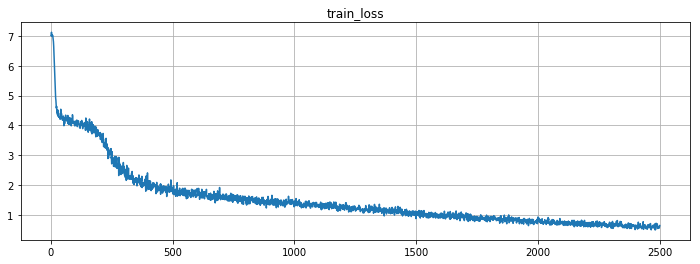

Mean loss=0.593


100%|██████████| 2500/2500 [04:41<00:00,  8.89it/s]


In [243]:
for _ in trange(2500):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        
# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

## Посмотрим, что вышло

In [263]:
for inp_line, query, generated_query in zip(test_inp[:50], test_out[:50], model.translate_lines(test_inp[::50])[0]):
    print("inp_line", inp_line)
    print("real query", query)
    print("generated query", generated_query)
    print()

inp_line display the id for those employees who did two or more jobs in the past .
real query select employee_id from job_history group by employee_id having count (*) >= 2
generated query select statement_id , last_name from employees order by birth_date desc limit 1

inp_line what are the last names and ages of the students who are allergic to m@@ il@@ k and cat ?
real query select lname , age from student where stuid in ( select stuid from has_allergy where allergy = " mil@@ k " intersect select stuid from has_allergy where allergy = " cat ")
generated query select count (*) from faculty

inp_line which cities have 2 to 4 parks ?
real query select city from park group by city having count (*) between 2 and 4 ;
generated query select count (*) from video_games

inp_line what are the names of the different artists from banglade@@ sh who never received a rating higher than a 7 ?
real query select distinct artist_name from artist where country = " bangladesh " except select distinct art

In [250]:
candidate_list = []
reference_list = []

for inp_line, query, generated_query in zip(test_inp, test_out, model.translate_lines(test_inp)[0]):
    candidate_list.append(generated_query)
    reference_list.append(query)

## Metrcic: accuracy
+1 к accuracy, если последовательность символов в запросе полностью совпадает с оригиналом

In [251]:
def is_all_same(c1, c2):
    if len(c1) == len(c2):
        all_same = True
        for j in range(len(c1)):
            if c1[j] != c2[j]:
                all_same = False
                break
        return all_same
    else:
        return False


def compute_accuracy(candidate_list, reference_list):
    if len(candidate_list) != len(reference_list):
        print("candidate list has length {}, reference list has length {}\n".format(len(candidate_list), len(reference_list)))

    len_min = min(len(candidate_list), len(reference_list))
    c = 0
    for i in range(len_min):
        #print(candidate_list[i])
        #print(reference_list[i])
        if is_all_same(candidate_list[i], reference_list[i]):
            #print("above was all same")
            c = c+1
    return c/float(len_min)

In [252]:
compute_accuracy(candidate_list, reference_list)

0.007132667617689016

### Attention

После работы энкодера есть последовательность его скрытых состояний, каждое из которых относиться к токену входной последовательности $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ 
Также есть скрытое состояние декодера с прошлого шага $h^d$,

* Считаем вот такое
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Считаем вес, с которым каждое слово во входной последовательности повлияет на декодер state.
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Добавляем ко внутренему состоянию декодера на предыдущем шаге взвешенную сумму внутренних состояний энкодера.
$$ attn = \sum_t p_t \cdot h^e_t $$

Чуть подробнее тут(https://distill.pub/2016/augmented-rnns/).

In [104]:
class AttentionLayer:
    def __init__(self, name, enc_size, dec_size, hid_size, activ=tf.tanh,):

        self.name = name
        self.enc_size = enc_size 
        self.dec_size = dec_size 
        self.hid_size = hid_size 
        self.activ = activ       

        with tf.variable_scope(name):
            
            self.linear_enc = L.Dense(hid_size)
            self.linear_dec = L.Dense(hid_size)
            self.out = L.Dense(1)

            # prepare to translate_lines
            self.inp = tf.placeholder('int32', [None, None])

    def __call__(self, enc, dec, inp_mask):
        with tf.variable_scope(self.name):
            
            
            adds = self.linear_enc(enc) + self.linear_dec(dec)[:, None, :]
            tanh = tf.tanh(adds)
            logits = self.out(adds)[:, :, 0]
            print (logits.shape)

            
           
            a = tf.equal(inp_mask, 0.0)
            b = logits
            c = tf.fill(tf.shape(logits), -1e9)
            
            logits = tf.where(a, logits, tf.fill(tf.shape(logits), -1e9))
            
            probs = tf.nn.softmax(logits)
            
           
            attn = tf.reduce_sum(tf.multiply(enc,probs), axis=2)
            attn = tf.reduce_sum(probs[:, :, None] * enc, axis=1)
            
            return attn, probs

### Seq2seq с вниманием(attention)


In [105]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        self.name = name
        self.inp_voc = inp_voc
        self.out_voc = out_voc

        with tf.variable_scope(name):
            
            
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)
            
            self.attn_layer = AttentionLayer("attn1", emb_size, emb_size, hid_size)

            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(out_voc))

            self.inp = tf.placeholder('int32', [None, None])
            self.initial_state = self.prev_state = self.encode(self.inp)
            self.prev_tokens = tf.placeholder('int32', [None])
            self.next_state, self.next_logits = self.decode(self.prev_state, self.prev_tokens)
        
        self.weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        

    def encode(self, inp, **flags):
        # encode input sequence, create initial decoder states
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_mask_ = infer_mask(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)
        with tf.variable_scope('enc0'):
            _, enc_last = tf.nn.dynamic_rnn(
                              self.enc0, inp_emb,
                              sequence_length=inp_lengths,
                              dtype = inp_emb.dtype)
        
        print ("enc_last shape ", _.shape)
        dec_start = self.dec_start(enc_last)
        print ("enc_last shape ", dec_start.shape)
        
        #!!! Attention мы добавляем в энкодер. Вот тут вся разница
        first_attn, first_attn_probas = self.attn_layer(inp_emb, dec_start, inp_mask_)
        
        first_state = [dec_start, inp_emb, inp_mask_, first_attn_probas]
        return first_state

    def decode(self, prev_state, prev_tokens, **flags):
       
        [dec_start, inp_emb, inp_mask_, first_attn_probas] = prev_state
        
        
        next_attn_response, next_attn_probas = self.attn_layer(inp_emb, dec_start, inp_mask_)
        
        prev_emb = self.emb_out(prev_tokens[:,None])[:,0]
        
        print ("shapes", prev_emb.shape, next_attn_response.shape)
        
        with tf.variable_scope('dec0'):
            aaa = tf.concat([next_attn_response, prev_emb], axis=-1)
            new_dec_out, new_dec_state = self.dec0(aaa, dec_start)
        output_logits = self.logits(new_dec_out)

        next_state = [new_dec_state, inp_emb, inp_mask_, next_attn_probas]
        return next_state, output_logits


In [106]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = AttentiveModel('model_attn', inp_voc, out_voc)

enc_last shape  (?, ?, 128)
enc_last shape  (?, 128)
(?, ?)
(?, ?)
shapes (?, 64) (?, 64)


### Training attentive model

We'll reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [107]:
inp = tf.placeholder('int32', [None, None])
out = tf.placeholder('int32', [None, None])

loss = compute_loss(model, inp, out)
train_step = tf.train.AdamOptimizer().minimize(loss)

enc_last shape  (?, ?, 128)
enc_last shape  (?, 128)
(?, ?)
(?, ?)
shapes (?, 64) (?, 64)


In [108]:
metrics = {'train_loss': []}
sess.run(tf.global_variables_initializer())
batch_size = 32

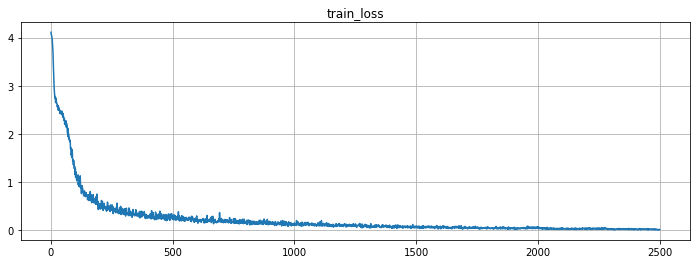

Mean loss=0.016


100%|██████████| 2500/2500 [07:48<00:00,  5.33it/s]


In [109]:
for _ in trange(2500):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    feed_dict = {
        inp: inp_voc.to_matrix(train_inp[batch_ix]),
        out: out_voc.to_matrix(train_out[batch_ix]),
    }
    
    loss_t, _ = sess.run([loss, train_step], feed_dict)
    metrics['train_loss'].append((step, loss_t))
    
    if step % 100 == 0:
        
        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
        

## Посмотрим, что вышло -2

In [74]:
model.translate_lines('Where is New York?')[0]

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

In [110]:
for inp_line, query, generated_query in zip(test_inp[:50], test_out[:50], model.translate_lines(test_inp[::50])[0]):
    print("inp_line", inp_line)
    print("real query", query)
    print("generated query", generated_query)
    print()

inp_line where is c0
real query ( lambda $ 0 e ( loc : t c0 $ 0 ) )
generated query ( lambda $ 0 e ( loc : t c0 $ 0 ) )

inp_line river in s0
real query ( lambda $ 0 e ( and ( river : t $ 0 ) ( loc : t $ 0 s0 ) ) )
generated query ( population : i c0 )

inp_line where are mountain
real query ( lambda $ 0 e ( exists $ 1 ( and ( mountain : t $ 1 ) ( loc : t $ 1 $ 0 ) ) ) )
generated query ( count $ 0 ( and ( state : t $ 0 ) ( next_to : t s0 $ 0 ) ) )

inp_line where is c0
real query ( lambda $ 0 e ( loc : t c0 $ 0 ) )
generated query ( argmax $ 0 ( and ( city : t $ 0 ) ( loc : t $ 0 s0 ) ) ( size : i $ 0 ) )

inp_line what state border s0
real query ( lambda $ 0 e ( and ( state : t $ 0 ) ( next_to : t $ 0 s0 ) ) )
generated query ( argmax $ 0 ( river : t $ 0 ) ( count $ 1 ( and ( state : t $ 1 ) ( loc : t r0 $ 1 ) ) )

inp_line what state border s0
real query ( lambda $ 0 e ( and ( state : t $ 0 ) ( next_to : t $ 0 s0 ) ) )
generated query ( argmax $ 0 ( and ( place : t $ 0 ) ( loc : t $

In [82]:
candidate_list = []
reference_list = []

for inp_line, query, generated_query in zip(test_inp, test_out, model.translate_lines(test_inp)[0]):
    candidate_list.append(generated_query)
    reference_list.append(query)

In [83]:
compute_accuracy(candidate_list, reference_list)

0.5836298932384342

чуть лучше

## А что не так?

* Машинные запросы "жестче", чем реальная речь. То есть если человек понимает магиста Йоду, машина вот такой запрос 

$) \lambda $ 0 e ( loc : t 0 $ c0 ( )$

вместо

$( \lambda $ 0 e ( loc : t c0 $/$$ 0 ) )$

понять уже не сможет

* Более того, одна ошибка - и запрос не выполнится

* Вышестоящая моделька выучиласть открывать/закрывать скобки, но обычно в seq2seq моделях это проблема.


## Seq2Tree model

* У логического выражения иерархическая структура

<img src="files/hierarical.png">

* В отличи от seq2seq, где каждый последующий в пространстве шаг зависит от предыдущего и неявно от всего входа(если attention), в иерархической структуре дети должны зависеть только от родителей и бабушек с дедушками, но не от сиблингов и тем более от "двоюродных братьев". Время вылета в запросе не зависит от города вылета

* Поэтому генерация проходит следующим образом:

В набор символов добавляется новый символ n, что означает начало дерева. 

Если выпал символ n, в следующее состояние передается не скрытое состояние n, а сумма всех состояний, сгенерированных на этом уровне до этого момента
<img src="files/tree_generate.png">

* Loss - такой же, accuracy - так же

## SQL запросы (WikiSQL)

* Qw: What record company did conductor Mikhail Snitko record for after 1996?

  Qu: SELECT Record Company WHERE (Year of Recording > 1996) AND (Conductor = Mikhail Snitko)
  
* Aggregation operation: SVG, COUNT, MIN, MAX, SUM ("How many" -> COUNT)

## RL approach

<img src="files/rl.png">

* предсказываем aggregation operation как возможный ответ классификатора ($Loss_{agg}$ - cross-entropy)
* предсказываем название колонки (SELECT) как возможный ответ классификатора ($Loss_{sel}$ - cross-entropy)
* предсказываем WHERE clause как последовательность. 
  
  Эта последовательность должна выполняться. 
  
  Если предсказанная последовательность невыполнима, reward = -2, если выполнима, но дает неверный ответ, -1; если выполнима и дает верный ответ, +1
  
  $Loss_{where}$ = -среднее reward по батчу
  
* Loss = $Loss_{agg}$ + $Loss_{sel}$ + $Loss_{where}$

**Почему reward, а не кросс-энтропия?**

запросы

**SELECT name FROM insurance WHERE age > 18 AND gender = "male"** 

**SELECT name FROM insurance WHERE gender = "male" AND age > 18**

 дают одинаковый верный результат, но один из них, например, совпадает с ответом из датасета, а другой нет. Вопорос на естественном языке **не взаимно однозначно** связан с его SQL-формой.

## Coarse-to-fine

**Qwestion: What record company did conductor Mikhail Snitko record for after 1996?**

**Expected query: SELECT Record Company WHERE (Year of Recording > 1996) AND (Conductor = Mikhail Snitko)**

* Энкодим входной вопрос на естественном языке

* Агррегатор и название колонки - классификатор на LSTM_encoder

* декодим скетч "WHERE > AND = "

* енкодим скетч

* декодим полный WHERE clause "SELECT Record Company WHERE (Year of Recording > 1996) AND (Conductor = Mikhail Snitko)"

* Profit!!!

Дальнейшие работы: генерировать where clause, которых нет в трейне